In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_solver import SpringRodsSystemSolver

from utils.computational_utils import l2_norm
from utils.plot_utils import plot_displacements_and_stress

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular'
})

In [3]:
experiment_setups = [
    {
        'body_forces': lambda x: np.where(x < 0, 1, -1)
    },
    {
        'body_forces': lambda x: np.where(x < 0, -1, 1)
    },
    {
        'body_forces': lambda x: np.where(x < 0, 1, 0)
    },
    {
        'body_forces': lambda x: np.where(x < 0, -1, 0)
    },
    {
        'body_forces': lambda x: np.where(x < 0, 1, 1)
    }
]

In [4]:
experiment_number = 1

In [5]:
model = SpringRodsSystemSetup(
    interval=(-1, 1),
    spring_len=1,
    step_size=1/128,
    material_const=(1, 1),
    spring_const=(1, 1),
    **experiment_setups[experiment_number - 1]
)
solver = SpringRodsSystemSolver(model)

In [6]:
positions = np.concatenate((model.domain[0], model.domain[1]))

In [7]:
spring_const_spectrum = np.linspace(0.01, 2, 100)
spring_const_discrete = [0.01, 0.5, 1, 2]

In [8]:
results = []

for const in tqdm(spring_const_discrete):
    model.set_spring_const((const, const))
    displacements = solver()

    stresses = solver.compute_stresses(displacements)
    results.append((displacements, stresses))

100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


In [9]:
# TODO checking if in all test cases spring is compressed or extended
# compressed = []
# for res in results:
#     displ = res[0]
#     left_end_displ = displ[model.nodes_num - 1]
#     right_end_displ = displ[model.nodes_num]
#     compressed.append(left_end_displ - right_end_displ > 0)

# if all(compressed):
#     stiff_coef = '$k_1$'
# elif not any(compressed):
#     stiff_coef = '$k_2$'
# else:
#     print(compressed)
#     print('lack of consistency')
#     print()
#     # raise Exception('lack of consistency')
stiff_coef = 'k'

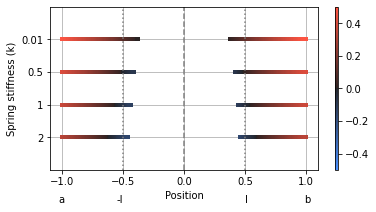

In [10]:
limits = (-0.5, 0.5)
assert np.min([v[1] for v in results]) > limits[0] and np.max([v[1] for v in results]) < limits[1]

plt.gcf().set_size_inches(6, 3)

plot_displacements_and_stress(
    model,
    results,
    spring_const_discrete,
    parameter_name=f'Spring stiffness ({stiff_coef})',
    limits=limits,
    path=f'./plots/spring_stiff_dependence/exp{experiment_number}_full.png'
)

In [11]:
left_end_results = []
right_end_results = []
displacement_results = []
stress_results = []

for idx, const in tqdm(enumerate(spring_const_spectrum, 1)):
    model.set_spring_const((const, const))
    displacements = solver()
    stress = solver.compute_stresses(displacements)

    displacement_results.append(displacements)
    stress_results.append(stress)
    left_end_results.append(displacements[0][-1])
    right_end_results.append(displacements[1][0])

100it [03:14,  1.95s/it]


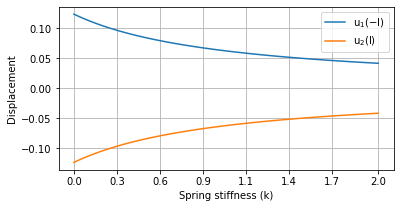

In [12]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

# TODO this is important for experiment 5
if experiment_number == 5:
    plt.ylim(-0.5, 0.5)

plt.plot(left_end_results, label='$u_1(-l)$')
plt.plot(right_end_results, label='$u_2(l)$')

x_ticks = np.linspace(0, len(spring_const_spectrum)-1, 8, dtype=int)
plt.xticks(x_ticks, (f'{x:.1f}' for x in spring_const_spectrum[x_ticks]))

plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.ylabel('Displacement')
plt.legend()

plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_ends_of_rods_displacement.png', bbox_inches='tight')

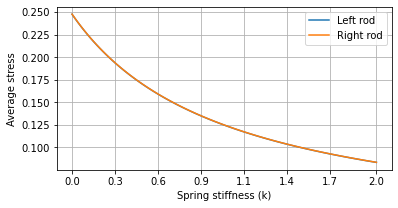

In [13]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

x_ticks = np.linspace(0, len(spring_const_spectrum)-1, 8, dtype=int)
plt.xticks(x_ticks, (f'{x:.1f}' for x in spring_const_spectrum[x_ticks]))


avg_stress_left = [np.average(s[0]) for s in stress_results]
avg_stress_right = [np.average(s[1]) for s in stress_results]
plt.plot(avg_stress_left, label='Left rod')
plt.plot(avg_stress_right, label='Right rod')
plt.ylabel('Average stress')
plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.legend()
plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_avg_stress.png', bbox_inches='tight')

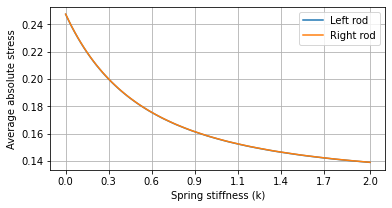

In [14]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

# TODO this is important for experiment 5
if experiment_number == 5:
    plt.ylim(-0.5, 0.5)

x_ticks = np.linspace(0, len(spring_const_spectrum)-1, 8, dtype=int)
plt.xticks(x_ticks, (f'{x:.1f}' for x in spring_const_spectrum[x_ticks]))


avg_stress_left = [np.average(np.abs(s[0])) for s in stress_results]
avg_stress_right = [np.average(np.abs(s[1])) for s in stress_results]
plt.plot(avg_stress_left, label='Left rod')
plt.plot(avg_stress_right, label='Right rod')
plt.ylabel('Average absolute stress')
plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.legend()
plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_avg_abs_stress.png', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


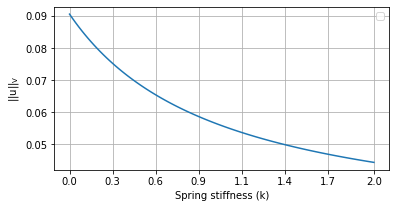

In [15]:
fig = plt.gcf()
fig.set_size_inches((6, 3))

x_ticks = np.linspace(0, len(spring_const_spectrum)-1, 8, dtype=int)
plt.xticks(x_ticks, (f'{x:.1f}' for x in spring_const_spectrum[x_ticks]))

norm_of_solution = [l2_norm(d, model.domain) for d in displacement_results]

plt.plot(norm_of_solution)
plt.ylabel('$\|\|u\|\|_{V}$')
plt.xlabel(f'Spring stiffness ({stiff_coef})')
plt.legend()
plt.savefig(f'plots/spring_stiff_dependence/exp{experiment_number}_avg_abs_stress.png', bbox_inches='tight')